# House Prices: Advanced Regression Techniques

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', 200)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [5]:
all_train_set = pd.read_csv('data/train.csv', index_col='Id')
all_test_set = pd.read_csv('data/test.csv', index_col='Id')

## Sale Price Distribution

/Users/zacstewart/Code/zacstewart/kaggle_house_prices/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


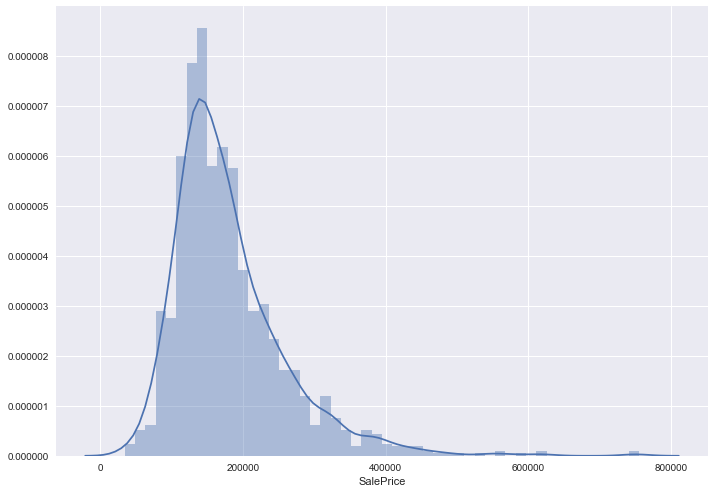

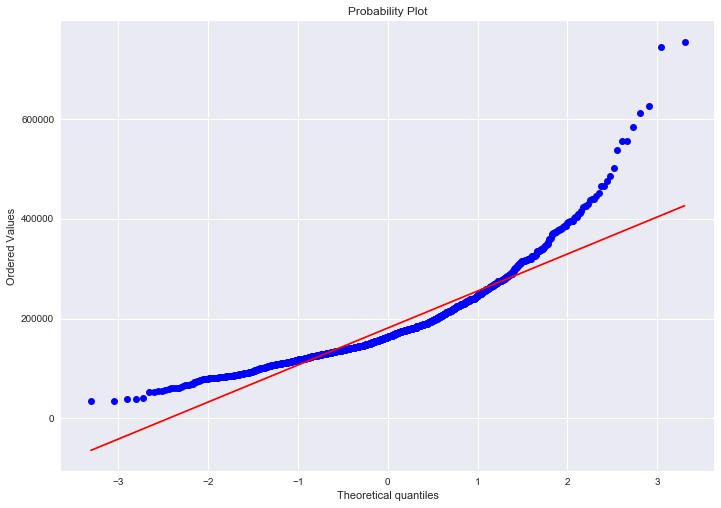

In [77]:
sns.distplot(all_train_set.SalePrice, bins=50)
fig = plt.figure()
res = stats.probplot(all_train_set['SalePrice'], plot=plt)
plt.show()

## Log Transformed Sale Price Distribution

In [79]:
all_train_set['LogSalePrice'] = np.log1p(all_train_set.SalePrice)

/Users/zacstewart/Code/zacstewart/kaggle_house_prices/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


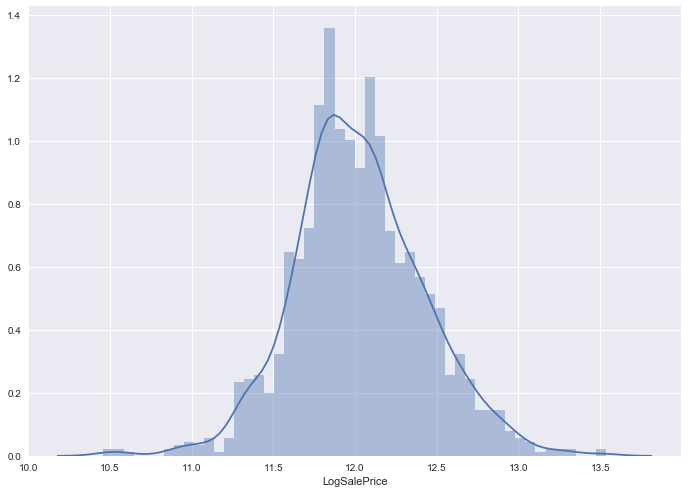

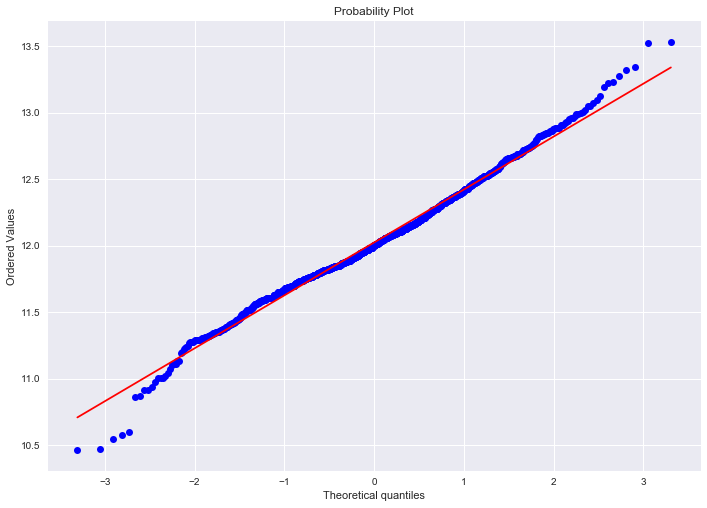

In [80]:
sns.distplot(all_train_set.LogSalePrice, bins = 50)
fig = plt.figure()
res = stats.probplot(all_train_set['LogSalePrice'], plot=plt)
plt.show()

## Features

In [9]:
all_train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220


### Feature Correlation

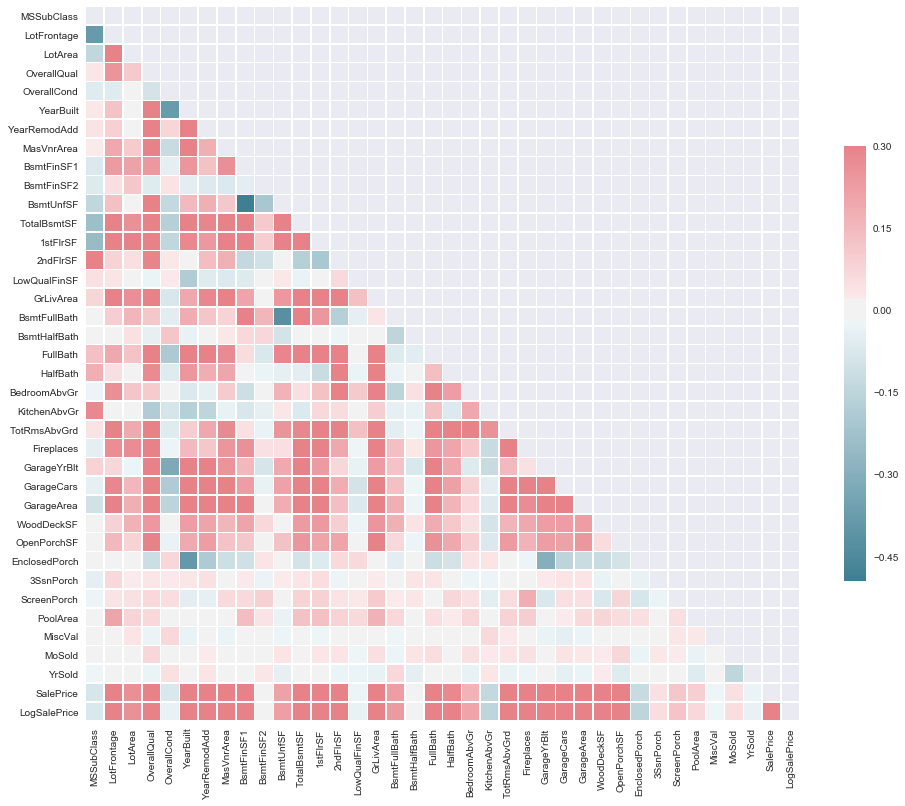

In [12]:
correlation = all_train_set.corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
correlation['SalePrice'].drop(['SalePrice', 'LogSalePrice']).abs().sort_values(ascending=False)

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

### Continuous

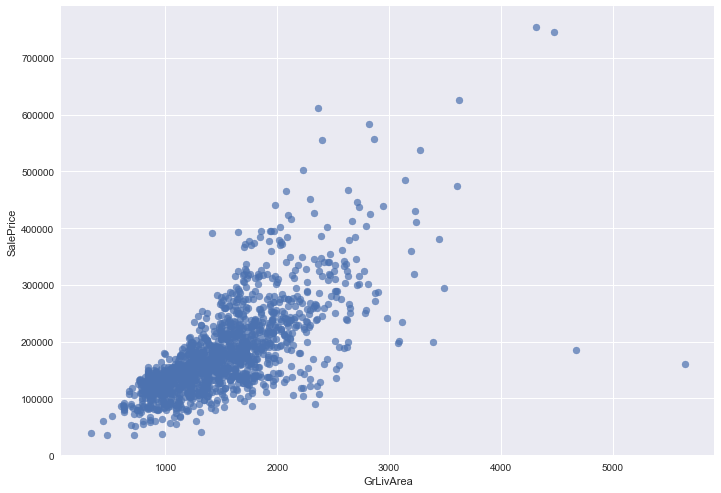

In [42]:
plt.scatter(data=all_train_set, x='GrLivArea', y='SalePrice', alpha=.7, )
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

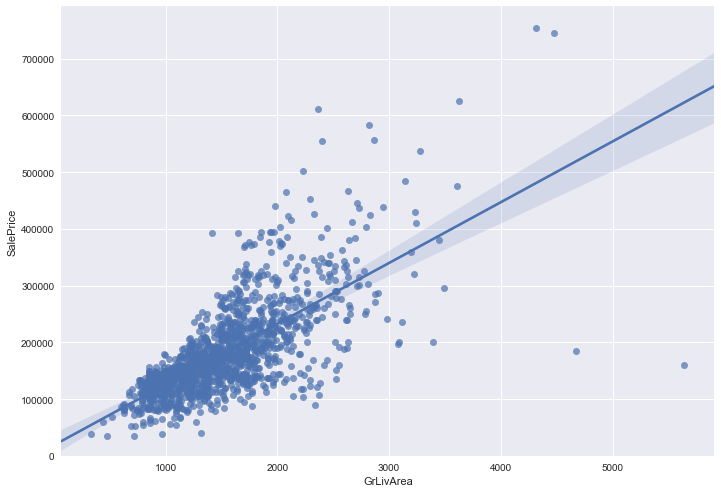

In [71]:
reg = sns.regplot(data=all_train_set, x='GrLivArea', y='SalePrice', scatter_kws={'alpha': .7})
reg.axes.set_ylim(0,)
plt.show()

### Discrete

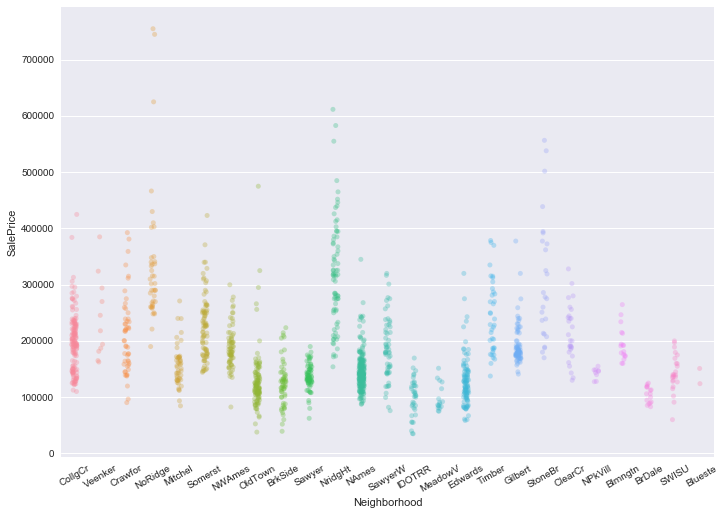

In [11]:
fig = sns.stripplot(data=all_train_set, x="Neighborhood", y="SalePrice", jitter=True, alpha=.33);
fig.set_xticklabels(fig.get_xticklabels(), rotation=30)
fig

## Dealing with Missing Data

In [86]:
len(all_train_set)

1460

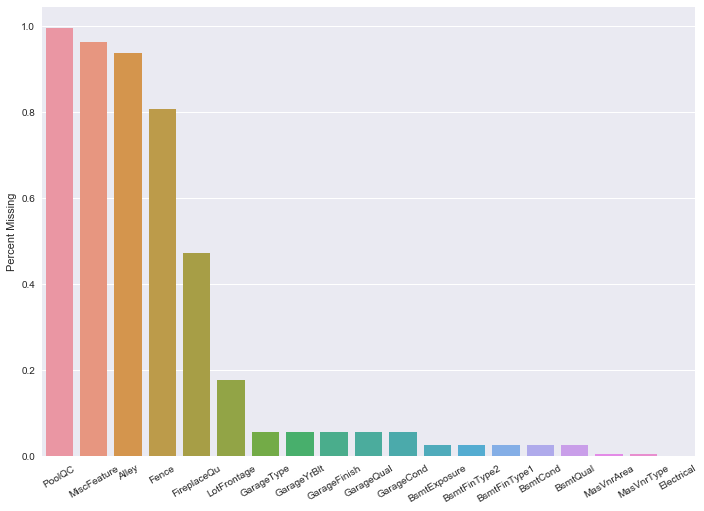

,Feature,Number Missing,Percent Missing
PoolQC,PoolQC,1453,0.995205
MiscFeature,MiscFeature,1406,0.963014
Alley,Alley,1369,0.937671
Fence,Fence,1179,0.807534
FireplaceQu,FireplaceQu,690,0.472603
LotFrontage,LotFrontage,259,0.177397
GarageType,GarageType,81,0.055479
GarageYrBlt,GarageYrBlt,81,0.055479
GarageFinish,GarageFinish,81,0.055479
GarageQual,GarageQual,81,0.055479


In [101]:
na_counts = all_train_set.isna().sum()
na_counts = na_counts[na_counts > 0]
missing_data = pd.DataFrame(index=na_counts.index, data={
    'Feature': na_counts.index,
    'Number Missing': na_counts,
    'Percent Missing': na_counts / len(all_train_set)
}).sort_values('Percent Missing', ascending=False)

fig = sns.barplot(data=missing_data.sort_values('Percent Missing', ascending=False),
                  x=missing_data.index,
                  y='Percent Missing')
fig.set_xticklabels(fig.get_xticklabels(), rotation=30)
plt.show()

missing_data

## Validate a Model

In [14]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict

In [44]:
class YearAndMonthTransformer(TransformerMixin):
    def __init__(self, year='YrSold', month='MoSold'):
        self.year = year
        self.month = month
        
    def fit(self, X, y=None, **fit_params):
        min_year = X[self.year].min()
        min_month = X[self.month].min()
        self.base_months = min_year * 12 + min_month
        return self 
    
    def transform(self, X, **transform_params):
        months = X[self.month].tolist()
        years = X[self.year].tolist()
        combined = []
        for (year, month) in zip(years, months):
            combined.append(year * 12 + month - self.base_months)
            
        return np.asarray(combined).reshape(len(combined), 1)

In [65]:
class ColumnSelector(TransformerMixin):
    
    def __init__(self, columns=[]):
        self.columns = columns
        
    def fit(self, X, y, **fit_params):
        return self
        
    def transform(self, X, **transform_params):
        return X[self.columns]
    

class FillNaTransformer(TransformerMixin):
    
    def __init__(self, fill_with):
        self.fill_with = fill_with
        
    def fit(self, X, y, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.fillna(self.fill_with)
    

class DebugTransformer(TransformerMixin):
    def fit(self, X, y):
        print("fit")
        print(X)
        print(y)
        return self
        
    def transform(self, X, y=None):
        print("transform")
        print(X)
        print(y) 
        return X
    
class ToDictTransformer(TransformerMixin):

    def fit(self, *_):
        return self

    def transform(self, X, **transform_params):
        return X.to_dict(orient='records')
    

def factor_feature(name):
    return (name, Pipeline([
        ('extract', ColumnSelector([name])),
        ('fill_na', FillNaTransformer('missing')),
        ('to_dict', ToDictTransformer()),
        ('label', DictVectorizer(sparse=False))
    ]))

def continuous_feature(name, default_value=0.0):
    return (name, Pipeline([
        ('extract', ColumnSelector([name])),
        ('fill_na', FillNaTransformer(default_value))
    ]))

In [102]:
regressors = [GradientBoostingRegressor(), Lasso(), ElasticNet(), Ridge()]
comparison = defaultdict(list)
comparison['truth'].extend(all_train_set['LogSalePrice'].data)

for regressor in regressors:
    regressor_name = regressor.__class__.__name__
    
    print('---', regressor_name, '----')
    
    model = Pipeline([
        ('features', FeatureUnion([
            continuous_feature('LotArea'),
            continuous_feature('YearBuilt'),
            continuous_feature('YearRemodAdd'),
            continuous_feature('BsmtFinSF1'),
            continuous_feature('BsmtFinSF2'),
            continuous_feature('BsmtUnfSF'),
            continuous_feature('TotalBsmtSF'),  # may be redundant
            continuous_feature('1stFlrSF'),
            continuous_feature('2ndFlrSF'),
            continuous_feature('LowQualFinSF'),
            continuous_feature('GrLivArea'),
            continuous_feature('BsmtFullBath'),
            continuous_feature('FullBath'),
            continuous_feature('HalfBath'),
            continuous_feature('BedroomAbvGr'),
            continuous_feature('KitchenAbvGr'),
            continuous_feature('TotRmsAbvGrd'),
            continuous_feature('Fireplaces'),
            continuous_feature('GarageYrBlt'),
            continuous_feature('GarageCars'),
            continuous_feature('GarageArea'),
            continuous_feature('LotFrontage'),
            continuous_feature('MasVnrArea'),
            continuous_feature('WoodDeckSF'),
            continuous_feature('OpenPorchSF'),
            continuous_feature('EnclosedPorch'),
            continuous_feature('3SsnPorch'),
            continuous_feature('ScreenPorch'),
            continuous_feature('PoolArea'),
            continuous_feature('MiscVal'),

            ## Categorical
            ('MSSubClass', Pipeline([
                ('extract', ColumnSelector(['MSSubClass'])),
                ('one_hot', OneHotEncoder())
            ])),

            factor_feature('MSZoning'),
            factor_feature('Street'),
            factor_feature('Alley'),
            factor_feature('LotShape'),
            factor_feature('LandContour'),
            factor_feature('Utilities'),
            factor_feature('LotConfig'),
            factor_feature('LandSlope'),
            factor_feature('Neighborhood'),
            factor_feature('Condition1'),
            factor_feature('Condition2'),
            factor_feature('BldgType'),
            factor_feature('HouseStyle'),
            factor_feature('OverallQual'),
            factor_feature('OverallCond'),
            factor_feature('RoofStyle'),
            factor_feature('RoofMatl'),
            factor_feature('Exterior1st'),
            factor_feature('Exterior2nd'),
            factor_feature('MasVnrType'),
            factor_feature('ExterQual'),
            factor_feature('ExterCond'),
            factor_feature('Foundation'),
            factor_feature('BsmtQual'),
            factor_feature('BsmtCond'),
            factor_feature('BsmtExposure'),
            factor_feature('BsmtFinType1'),
            factor_feature('Heating'),
            factor_feature('HeatingQC'),
            factor_feature('CentralAir'),
            factor_feature('Electrical'),
            factor_feature('KitchenQual'),
            factor_feature('Functional'),
            factor_feature('FireplaceQu'),
            factor_feature('GarageType'),
            factor_feature('GarageFinish'),
            factor_feature('GarageQual'),
            factor_feature('GarageCond'),
            factor_feature('PavedDrive'),
            factor_feature('PoolQC'),
            factor_feature('Fence'),
            factor_feature('MiscFeature'),
            factor_feature('SaleType'),
            factor_feature('SaleCondition'),

            ('YearAndMonth', YearAndMonthTransformer())

        ])),
        ('regressor', regressor)
    ])

    np.random.seed(0)
    kfold = KFold(5)
    rmses = []

    for (train_idx, cv_idx) in kfold.split(all_train_set):
        construct = all_train_set.iloc[train_idx]
        validate = all_train_set.iloc[cv_idx]

        construct_X = construct
        construct_y = construct['LogSalePrice']

        validate_X = validate
        validate_y = validate['LogSalePrice']

        model.fit(construct_X, y=construct_y)
        predictions = model.predict(validate_X)
        rmse = np.sqrt(mean_squared_error(validate_y, predictions))
        rmses.append(rmse)
        print(rmse)

        comparison[regressor_name].extend(predictions)

    print('mean', np.mean(rmses), '\n')

--- GradientBoostingRegressor ----
0.1181512204407997
0.1419139827597604
0.12899755697792026
0.11367601552542335
0.1263244790480808
mean 0.1258126509503969 

--- Lasso ----
0.1626338221900735
0.20139020120313098
0.1743072091829876
0.18101004252333106
0.26258951320915835
mean 0.1963861576617363 

--- ElasticNet ----
0.15798558408446592
0.19557538283367204
0.16458710780389665
0.17274135555876136
0.254947007284171
mean 0.18916728751299342 

--- Ridge ----
0.2075561714174375
0.24318036227070863
0.22200974124196937
0.22298889975448544
0.299222518083722
mean 0.2389915385536646 



In [177]:
df = pd.DataFrame(columns=['order', 'value', 'source'])
sorted_indices = np.argsort(comparison['truth'])

for (name, preds) in comparison.items():
    df = df.append([
        dict(order=i, value=p, source=name)
        for (i, p) in enumerate(np.asarray(preds)[sorted_indices])])

In [196]:
df['Truth'] = df['source'] == 'truth'

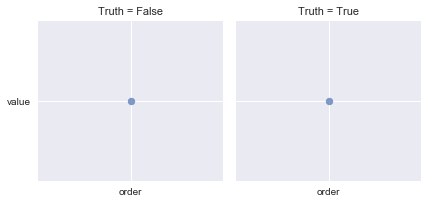

In [203]:
g = sns.FacetGrid(df, col="Truth")
g.map(plot.scatter, x='order', y='value', alpha=.7)
g.add_legend();
# sns.stripplot(data=df, x='order', y='value', hue='Truth', alpha=0.1)

In [178]:
df.source.unique()

array(['truth', 'GradientBoostingRegressor', 'Lasso', 'ElasticNet',
       'Ridge'], dtype=object)

## Make a Submission

In [10]:
model.fit(all_train_set, y=all_train_set['SalePrice'])

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('LotArea', Pipeline(memory=None,
     steps=[('extract', <__main__.ColumnSelector object at 0x10ca0a940>), ('fill_na', <__main__.FillNaTransformer object at 0x10ca0a978>)])), ('YearBuilt', Pipeline(memory=None,
     steps=[('extrac...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [11]:
predictions = model.predict(all_test_set)

In [12]:
predictions

array([118999.6314348 , 157403.35824132, 186154.82394311, ...,
       166937.45049332, 134141.17259573, 228159.66078908])

In [13]:
submission = pd.DataFrame({'Id': all_test_set['Id'], 'SalePrice': predictions})

In [51]:
submission.to_csv('submission.csv', index=False)